# 1 Dataset and Task
 (a) Select your choice of neural networks model that is suitable for this task and motivate it. Train your model
 to predict one step ahead data point, during training (see following Figure). Scale your data before training
 and scale them back to be able to compare your predictions with real measurements.
 
 (b) How many past time steps should you input into your network to achieve the best possible performance?
 (Hint: This is a tunable parameter and needs to be tuned).
 
 (c) Once your model is trained, use it to predict the next 200 data points recursively. This means feeding each
 prediction back into the model to generate the subsequent predictions.)
 
 (d) On May 9th, download the real test dataset and evaluate your model by reporting both the Mean Absolute
 Error (MAE) and Mean Squared Error (MSE) between its predictions and the actual test values. Additionally,
 create a plot comparing the predicted and real values to visually assess your models performance.

First, we load the data and take a look at it. We also install torch:

Data shape: (1000, 1)
Data type: uint8
Min value: 2
Max value: 255


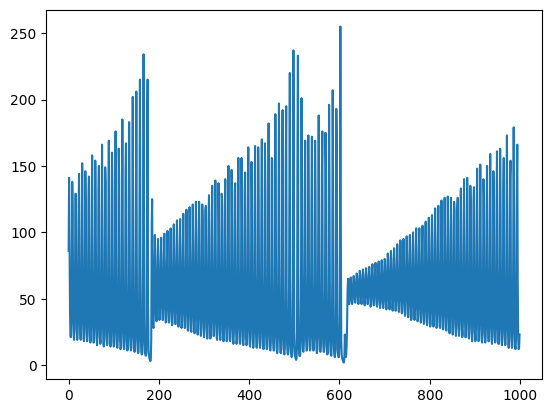

In [4]:
file = 'Xtrain.mat'
# load training data
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Load the training data
data = scipy.io.loadmat(file)
X_train = data['Xtrain']

# Display basic information about the data
print(f"Data shape: {X_train.shape}")
print(f"Data type: {X_train.dtype}")
print(f"Min value: {np.min(X_train)}")
print(f"Max value: {np.max(X_train)}")

# plot the data
plt.plot(X_train)
plt.show()


Now, we scale the data, because then the network works better and faster. 
I also want to scale it back, so that it can get the right outputs.

In [35]:
import sklearn
from sklearn.preprocessing import StandardScaler

#let's scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_train.reshape(-1, 1))

#We also want the scaled back data ready:
restored_data = scaler.inverse_transform(scaled_data)

# Printing the first few values of the scaled and restored data to check
print(f"First few scaled values:\n{scaled_data[:5]}")
print(f"First few restored values:\n{restored_data[:5]}")

#Display basic information about the data
print(f"Data shape: {scaled_data.shape}")
print(f"Data type: {scaled_data.dtype}")
print(f"Min value: {np.min(scaled_data)}")
print(f"Max value: {np.max(scaled_data)}")

First few scaled values:
[[ 0.55720154]
 [ 1.73111118]
 [ 0.74929585]
 [-0.40326998]
 [-0.8088024 ]]
First few restored values:
[[ 86.]
 [141.]
 [ 95.]
 [ 41.]
 [ 22.]]
Data shape: (1000, 1)
Data type: float64
Min value: -1.2356786270219065
Max value: 4.16430570013708


In [44]:
from torch.utils.data import TensorDataset, DataLoader
#Now we want to create sequences from our data, then split into training, validation, and test sets
seq_len = 30

#Define the function that retrieves the sequences:
def create_sequences(data, seq_len):
    sequences = []
    labels = []
    for i in range(len(data) - seq_len):
        seq = data[i:i+seq_len]
        label = data[i+seq_len]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Define the split point for test data - we'll use the last portion for testing
test_ratio = 0.20
val_ratio = 0.1
train_ratio = 0.70

# Calculate sizes
total_size = len(scaled_data)
test_size = int(test_ratio * total_size)
val_size = int(val_ratio * (total_size - test_size))
train_size = total_size - test_size - val_size

# Split the data before creating sequences
train_val_data = scaled_data[:-test_size]
test_data = scaled_data[-test_size:]

# Create sequences only for training and validation data
X_sequences, y_labels = create_sequences(train_val_data, seq_len)

# Convert to PyTorch tensors
X_sequences = torch.tensor(X_sequences, dtype=torch.float32)
y_labels = torch.tensor(y_labels, dtype=torch.float32)

# Create a TensorDataset
dataset = TensorDataset(X_sequences, y_labels)

# Calculate sizes for train and validation
dataset_size = len(dataset)
train_size = int(train_ratio / (train_ratio + val_ratio) * dataset_size)
val_size = dataset_size - train_size

# Split the dataset for train and validation
train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Create DataLoaders for training and validation
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# We keep test_data as is (not split into sequences) for autoregressive prediction

# Print information about the splits
print(f"Total data points: {total_size}")
print(f"Training sequences: {train_size}")
print(f"Validation sequences: {val_size}")
print(f"Test data points: {len(test_data)}")


Total data points: 1000
Training sequences: 673
Validation sequences: 97
Test data points: 200


In [45]:
#making the LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # use output from last time step
        out = self.fc(out)
        return out

Epoch 1/1000 - Train Loss: 0.9957 - Val Loss: 1.2249 (Best Model Saved)
Epoch 2/1000 - Train Loss: 0.9929 - Val Loss: 1.2222 (Best Model Saved)
Epoch 3/1000 - Train Loss: 0.9902 - Val Loss: 1.2194 (Best Model Saved)
Epoch 4/1000 - Train Loss: 0.9875 - Val Loss: 1.2167 (Best Model Saved)
Epoch 5/1000 - Train Loss: 0.9849 - Val Loss: 1.2141 (Best Model Saved)
Epoch 6/1000 - Train Loss: 0.9823 - Val Loss: 1.2114 (Best Model Saved)
Epoch 7/1000 - Train Loss: 0.9797 - Val Loss: 1.2086 (Best Model Saved)
Epoch 8/1000 - Train Loss: 0.9772 - Val Loss: 1.2059 (Best Model Saved)
Epoch 9/1000 - Train Loss: 0.9746 - Val Loss: 1.2031 (Best Model Saved)
Epoch 10/1000 - Train Loss: 0.9720 - Val Loss: 1.2002 (Best Model Saved)
Epoch 11/1000 - Train Loss: 0.9694 - Val Loss: 1.1973 (Best Model Saved)
Epoch 12/1000 - Train Loss: 0.9667 - Val Loss: 1.1942 (Best Model Saved)
Epoch 13/1000 - Train Loss: 0.9640 - Val Loss: 1.1911 (Best Model Saved)
Epoch 14/1000 - Train Loss: 0.9612 - Val Loss: 1.1878 (Best 

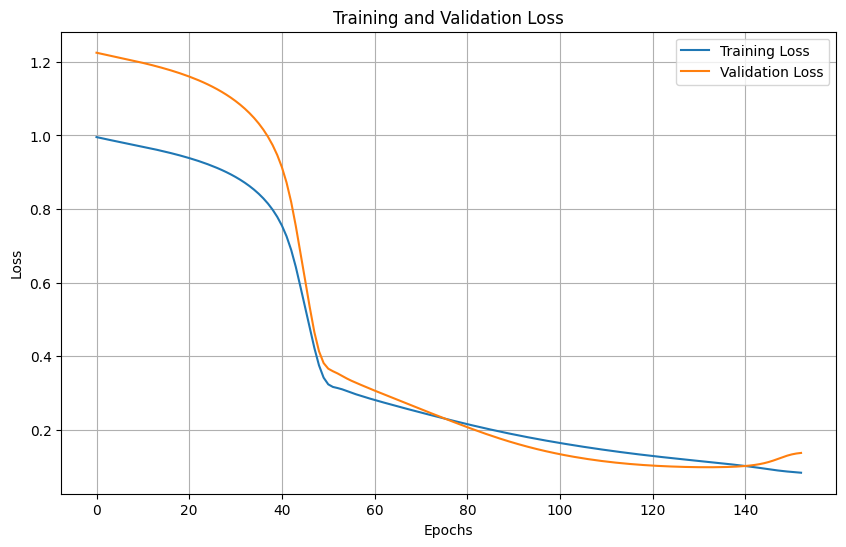

Test MAE: 44.0332
Test MSE: 3577.4374


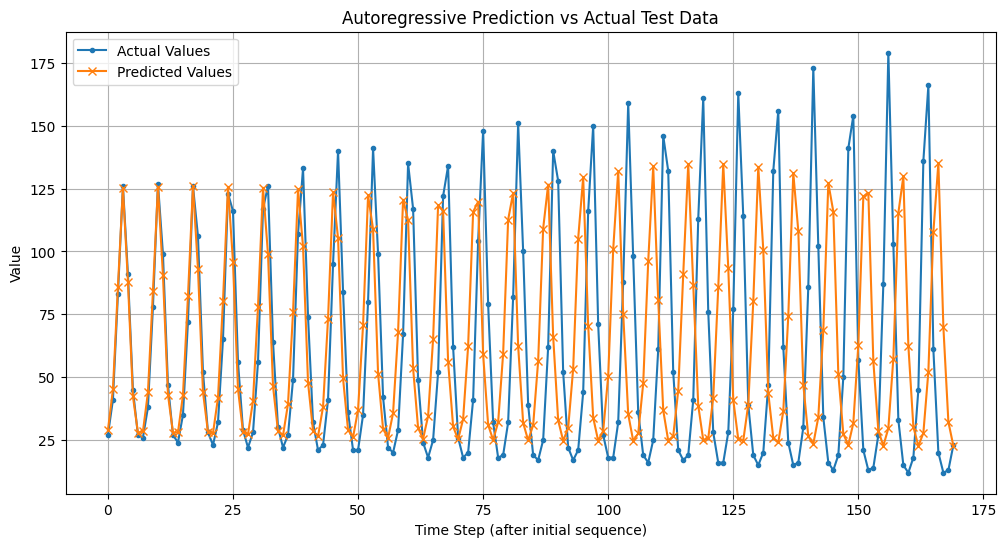

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel(hidden_size=64, num_layers=1, dropout=0.0).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# training loop with early stopping
num_epochs = 1000
train_losses, val_losses = [], []
best_val_loss = float('inf')
best_model_state = None
best_epoch = -1
patience = 20  # number of epochs to wait for improvement
counter = 0  # counter for patience

for epoch in range(num_epochs):
    # train
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output.squeeze(), y_batch.squeeze())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            loss = criterion(output.squeeze(), y_batch.squeeze())
            val_loss += loss.item()
    
    # record losses
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # save the best model and check for early stopping
    if val_loss < best_val_loss:
        best_epoch = epoch
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
        counter = 0  # reset counter
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} (Best Model Saved)")
    else:
        counter += 1  # increment counter
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")
        
    # early stopping check
    if counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

# load best model
model.load_state_dict(best_model_state)
print(f"Best validation loss: {best_val_loss:.4f} for epoch {best_epoch}")

## plot losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()




# %%
# autoregressive prediction on the test set
model.eval()
predictions = []
initial_sequence_np = test_data[:seq_len].reshape(1, seq_len, 1)
current_sequence = torch.tensor(initial_sequence_np, dtype=torch.float32).to(device)

num_predictions = len(test_data) - seq_len

with torch.no_grad():
    for _ in range(num_predictions):
        prediction = model(current_sequence)
        predictions.append(prediction.item())
        # append the prediction and remove the oldest point
        new_point = prediction.reshape(1, 1, 1)
        current_sequence = torch.cat((current_sequence[:, 1:, :], new_point), dim=1)

# inverse transform predictions and actual test data
predicted_values = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
actual_values = scaler.inverse_transform(test_data[seq_len:]) # compare against the part of test_data we predicted

# calculate mae and mse
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)

print(f"Test MAE: {mae:.4f}")
print(f"Test MSE: {mse:.4f}")

# plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(actual_values, label='Actual Values', marker='.')
plt.plot(predicted_values, label='Predicted Values', marker='x')
plt.title('Autoregressive Prediction vs Actual Test Data')
plt.xlabel('Time Step (after initial sequence)')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()
